In [1]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import louvain

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
%config InlineBackend.figure_format='retina'

# Loading the Data

In [3]:
SCRNA_DIR = '../data/scRNA/'

In [4]:
%%time
scrna = sc.read_10x_mtx(SCRNA_DIR, var_names='gene_ids', cache=True)

var = pd.read_csv(SCRNA_DIR + 'var.csv')
var.index = var.gene_name
scrna.var = var

obs = pd.read_csv(SCRNA_DIR + 'obs.csv')
obs.index = obs.iloc[:,0]
scrna.obs = obs

CPU times: user 3.1 s, sys: 1.42 s, total: 4.52 s
Wall time: 7.93 s


In [5]:
scrna

AnnData object with n_obs × n_vars = 53638 × 20287 
    obs: 'Unnamed: 0', 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'ProjectUMAP1', 'ProjectUMAP2', 'ProjectClassification', 'Barcode'
    var: 'gene_name', 'gene_id', 'exonLength'

In [6]:
scrna.obs.head()

Unnamed: 0      Group  nUMI_pre  nUMI  \
Unnamed: 0                                                                  
RM2:AAACCTGAGTGTCCCG-1  RM2:AAACCTGAGTGTCCCG-1  MPAL5R_T1      1802  1441   
RM2:AAAGATGGTCCGAGTC-1  RM2:AAAGATGGTCCGAGTC-1  MPAL5R_T1     12368  7988   
RM2:AAATGCCCAAATTGCC-1  RM2:AAATGCCCAAATTGCC-1  MPAL5R_T1      1945  1036   
RM2:AAATGCCTCGTTACAG-1  RM2:AAATGCCTCGTTACAG-1  MPAL5R_T1      2529  1551   
RM2:AACACGTAGGAGCGAG-1  RM2:AACACGTAGGAGCGAG-1  MPAL5R_T1      5864  3774   

                        nGene  ProjectUMAP1  ProjectUMAP2  \
Unnamed: 0                                                  
RM2:AAACCTGAGTGTCCCG-1    896     -6.581877      3.819128   
RM2:AAAGATGGTCCGAGTC-1   3029     -6.184691      2.277092   
RM2:AAATGCCCAAATTGCC-1    600     -5.550443      2.505810   
RM2:AAATGCCTCGTTACAG-1    957     -5.936206      2.888241   
RM2:AACACGTAGGAGCGAG-1   1592     -6.512098     -0.113418   

                       ProjectClassification             Barcode  
Unnamed: 0                                                        
RM2:AAACCTGAGTGTCCCG-1       Progenitor_Like  AAACCTGAGTGTCCCG-1  
RM2:AAAGATGGTCCGAGTC-1          Myeloid_Like  AAAGATGGTCCGAGTC-1  
RM2:AAATGCCCAAATTGCC-1          Myeloid_Like  AAATGCCCAAATTGCC-1  
RM2:AAATGCCTCGTTACAG-1       Progenitor_Like  AAATGCCTCGTTACAG-1  
RM2:AACACGTAGGAGCGAG-1          Myeloid_Like  AACACGTAGGAGCGAG-1

# Data Cleaning

In [7]:
scrna.obs.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
scrna.obs.rename(columns={'ProjectClassification': 'cell_type'}, inplace=True)

In [9]:
scrna.obsm['X_umap'] = scrna.obs[['ProjectUMAP1', 'ProjectUMAP2']].to_numpy()
scrna.obs.drop(['ProjectUMAP1', 'ProjectUMAP2'], axis=1, inplace=True)

In [10]:
scrna.obs['condition'] = scrna.obs['cell_type'].map(lambda a: 'stimulated' if a.endswith('Like') else 'control')

In [11]:
scrna.obs.head()

Group  nUMI_pre  nUMI  nGene        cell_type  \
Unnamed: 0                                                                  
RM2:AAACCTGAGTGTCCCG-1  MPAL5R_T1      1802  1441    896  Progenitor_Like   
RM2:AAAGATGGTCCGAGTC-1  MPAL5R_T1     12368  7988   3029     Myeloid_Like   
RM2:AAATGCCCAAATTGCC-1  MPAL5R_T1      1945  1036    600     Myeloid_Like   
RM2:AAATGCCTCGTTACAG-1  MPAL5R_T1      2529  1551    957  Progenitor_Like   
RM2:AACACGTAGGAGCGAG-1  MPAL5R_T1      5864  3774   1592     Myeloid_Like   

                                   Barcode   condition  
Unnamed: 0                                              
RM2:AAACCTGAGTGTCCCG-1  AAACCTGAGTGTCCCG-1  stimulated  
RM2:AAAGATGGTCCGAGTC-1  AAAGATGGTCCGAGTC-1  stimulated  
RM2:AAATGCCCAAATTGCC-1  AAATGCCCAAATTGCC-1  stimulated  
RM2:AAATGCCTCGTTACAG-1  AAATGCCTCGTTACAG-1  stimulated  
RM2:AACACGTAGGAGCGAG-1  AACACGTAGGAGCGAG-1  stimulated

# Quality Control

Data is already quality controlled by the authors. Here we just plot to show this fact.

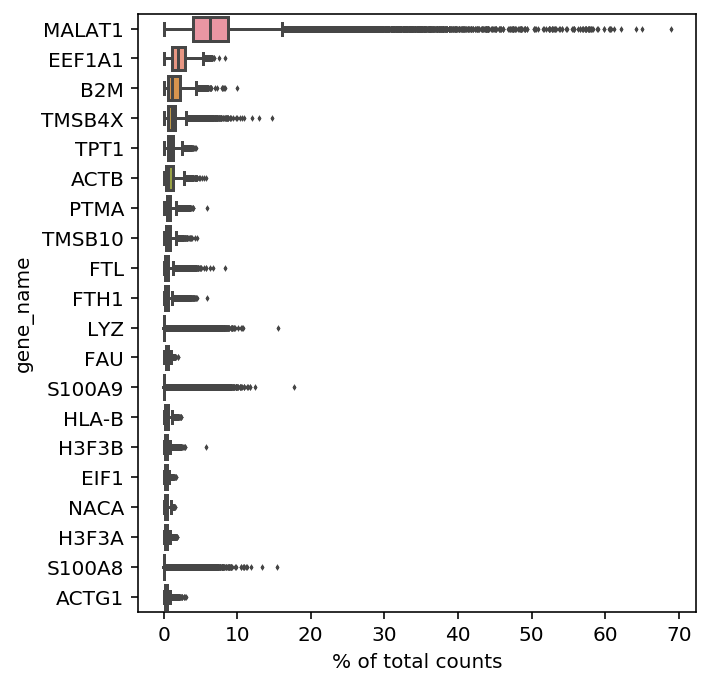

In [12]:
sc.pl.highest_expr_genes(scrna, n_top=20)

... storing 'Group' as categorical
... storing 'cell_type' as categorical
... storing 'Barcode' as categorical
... storing 'condition' as categorical


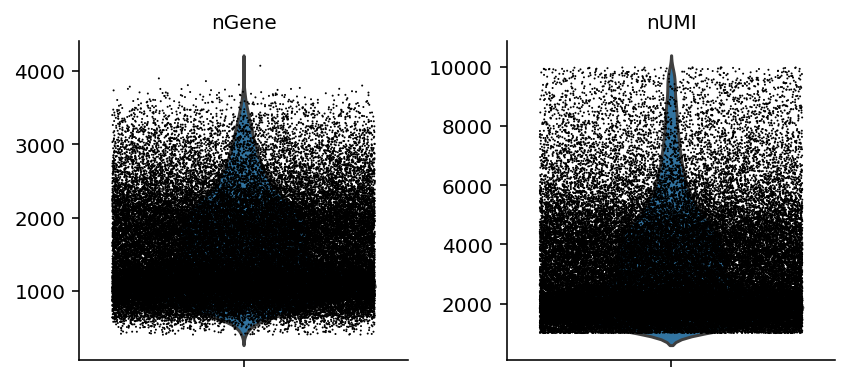

In [13]:
sc.pl.violin(scrna, ['nGene', 'nUMI'], jitter=0.4, multi_panel=True)

# Normalization

In [14]:
sc.pp.normalize_total(scrna, target_sum=1e4)
sc.pp.log1p(scrna)

In [15]:
scrna

AnnData object with n_obs × n_vars = 53638 × 20287 
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition'
    var: 'gene_name', 'gene_id', 'exonLength'
    obsm: 'X_umap'

# Filtering Highly Variable Genes

In [16]:
sc.pp.highly_variable_genes(scrna, n_top_genes=3000)

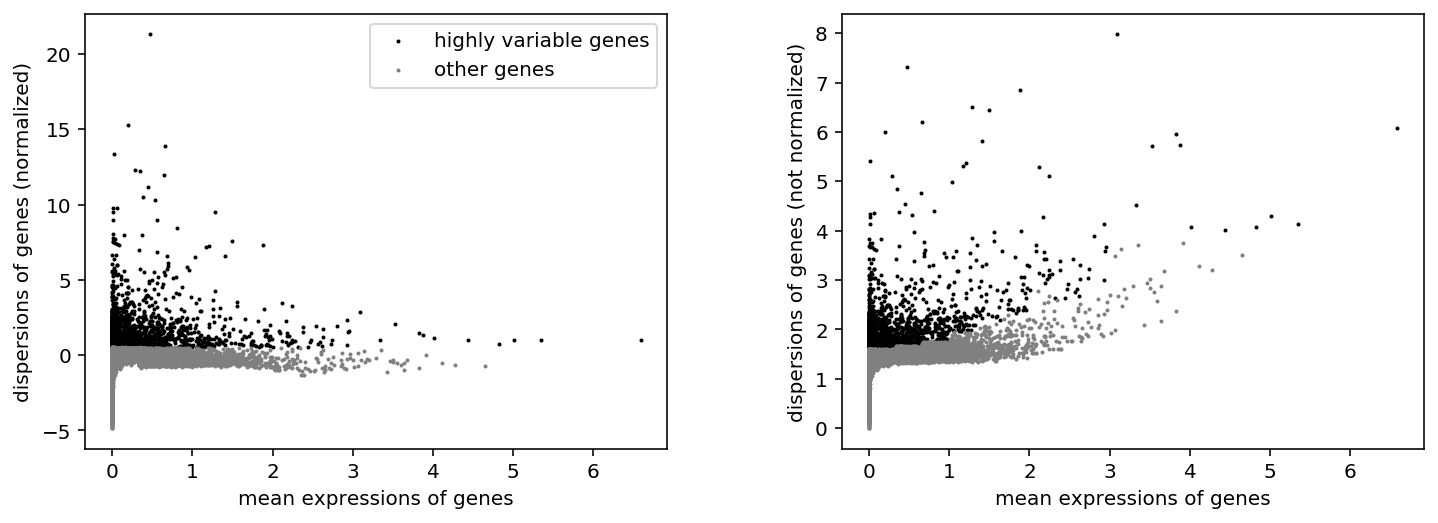

In [17]:
sc.pl.highly_variable_genes(scrna)

In [18]:
scrna = scrna[:, scrna.var.highly_variable]
scrna

View of AnnData object with n_obs × n_vars = 53638 × 3000 
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition'
    var: 'gene_name', 'gene_id', 'exonLength', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_umap'

# Visualization

## UMAP using coordinates provided by the authors

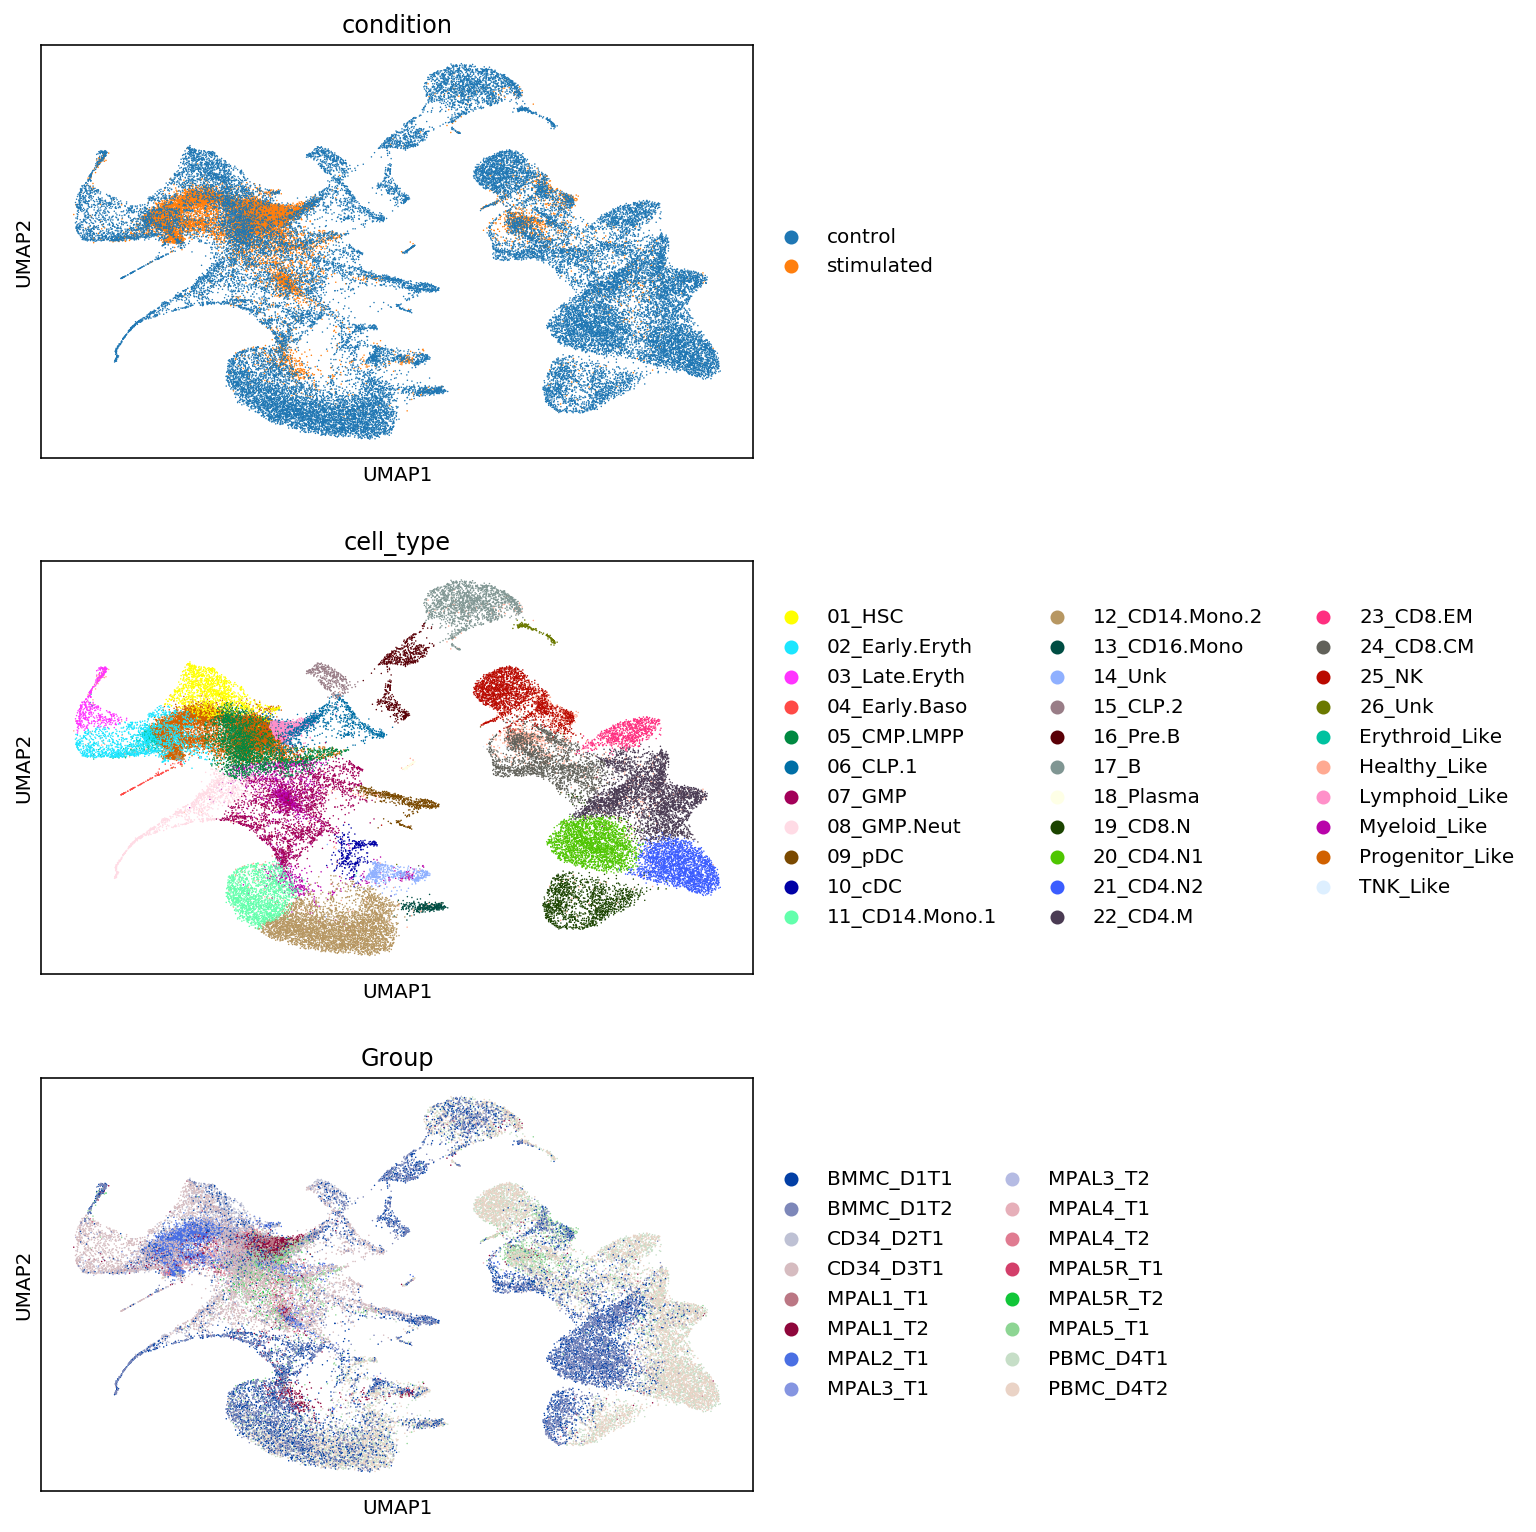

In [19]:
sc.pl.umap(scrna, color=['condition', 'cell_type', 'Group'], ncols=1)

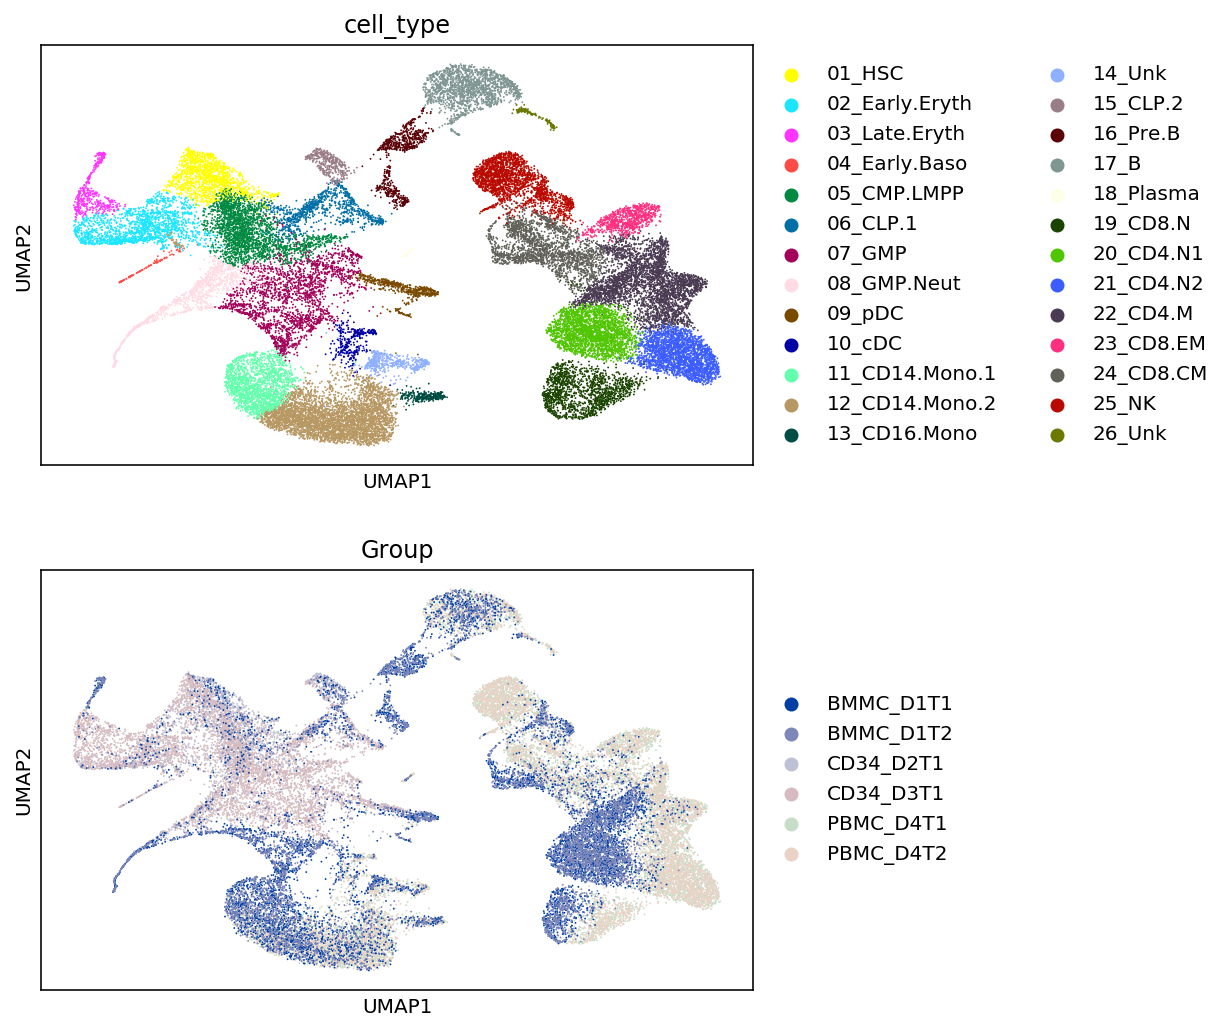

In [20]:
sc.pl.umap(scrna[scrna.obs['condition'] == 'control'], color=['cell_type', 'Group'], ncols=1)

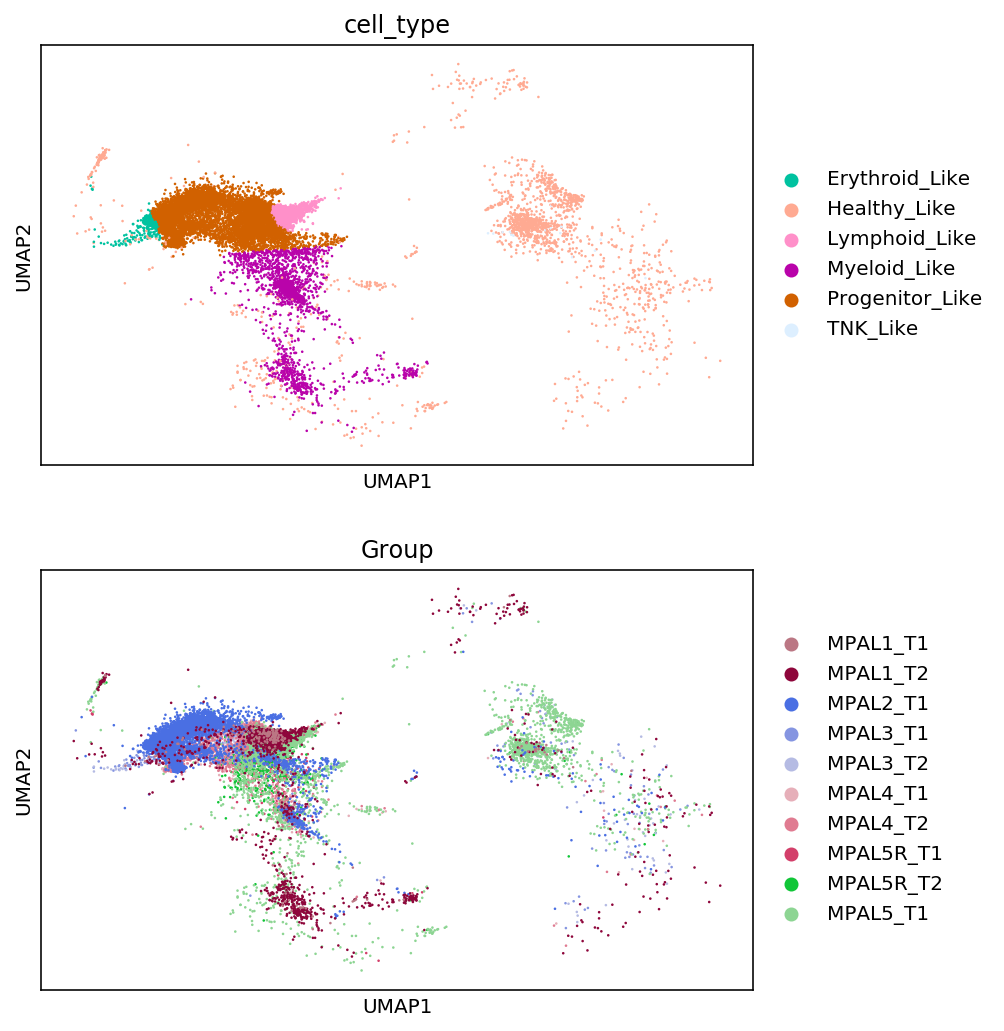

In [21]:
sc.pl.umap(scrna[scrna.obs['condition'] == 'stimulated'], color=['cell_type', 'Group'], ncols=1)

## Running UMAP

In [22]:
adata = scrna

In [23]:
sc.pp.neighbors(adata, random_state=42)
sc.tl.umap(adata, random_state=42)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anac

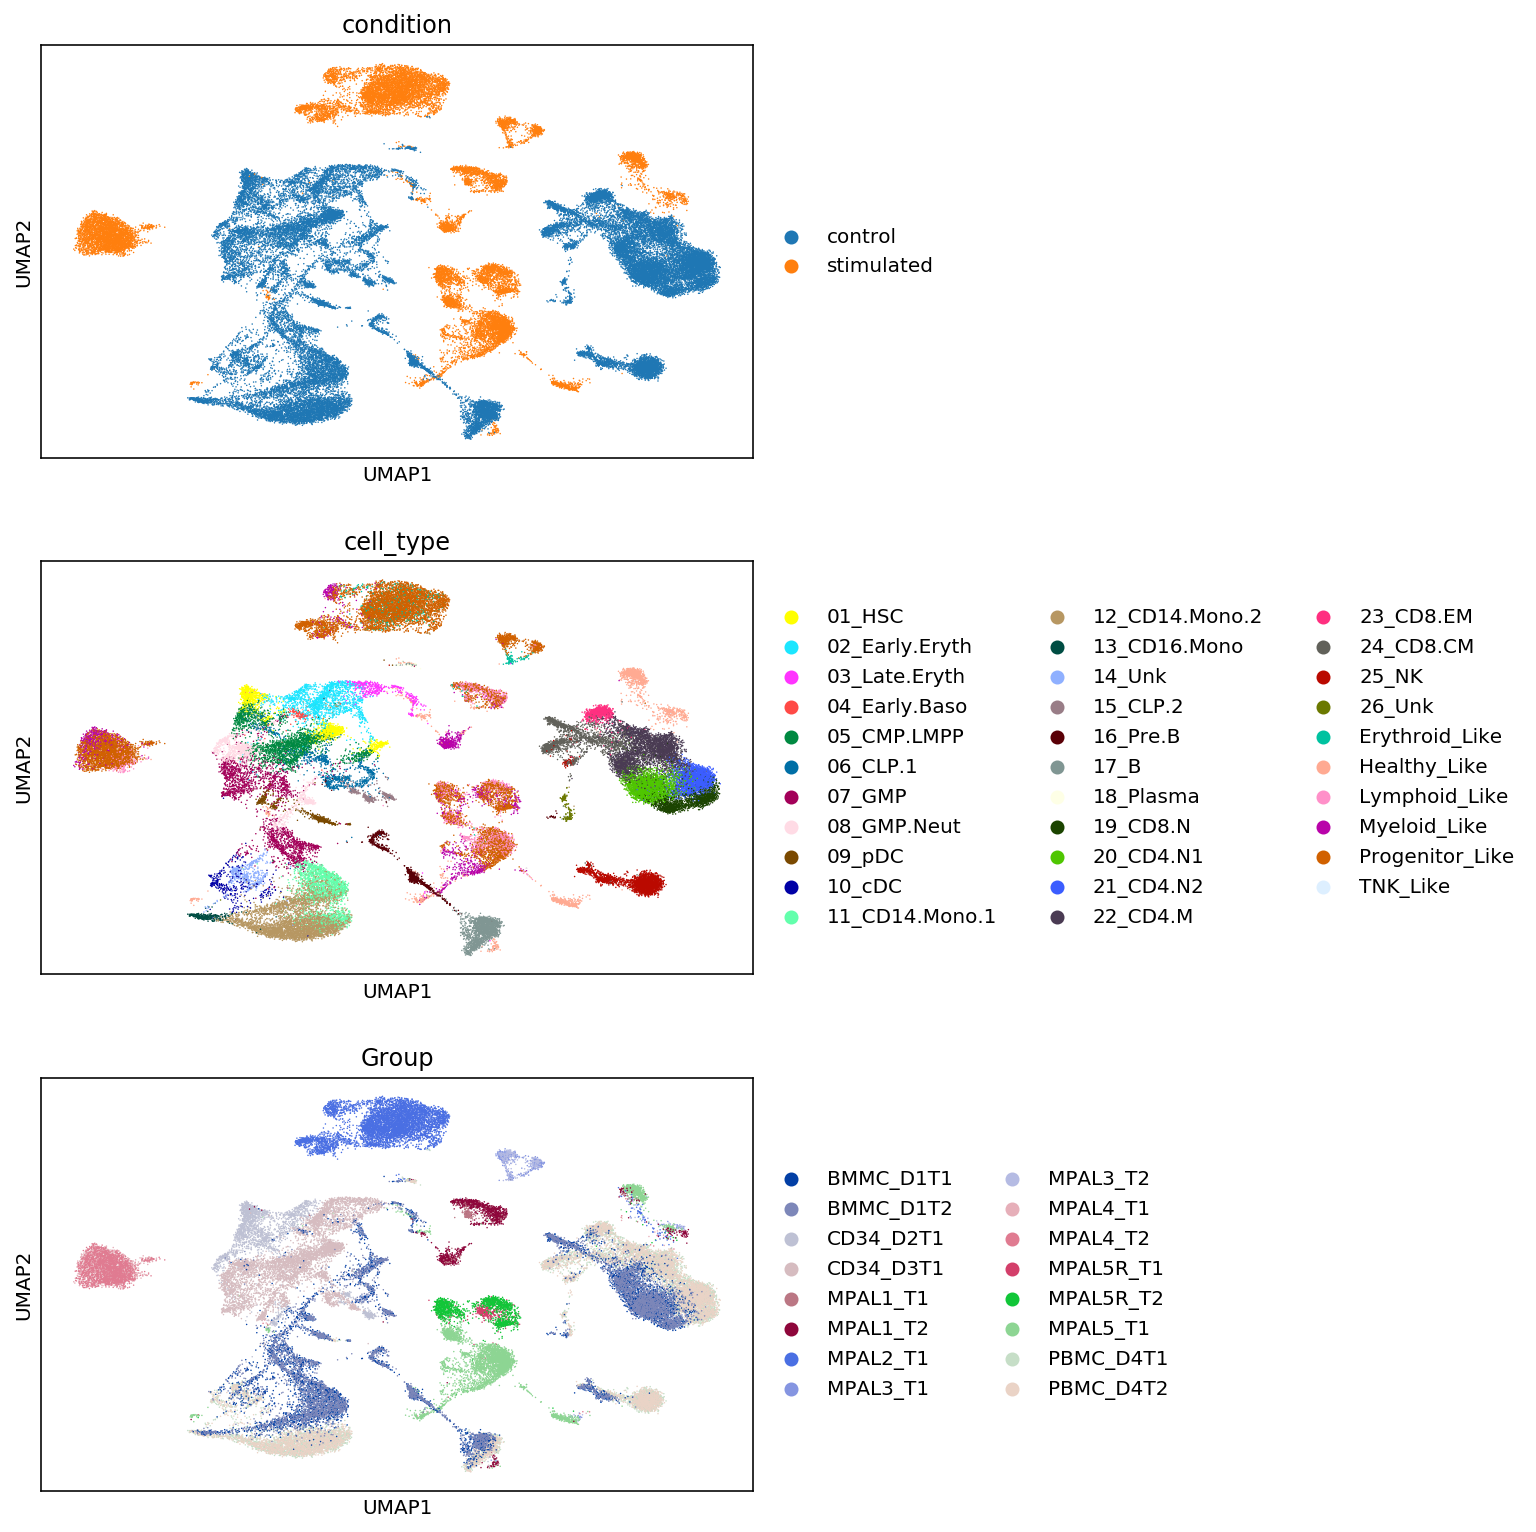

In [24]:
sc.pl.umap(adata, color=['condition', 'cell_type', 'Group'], ncols=1)

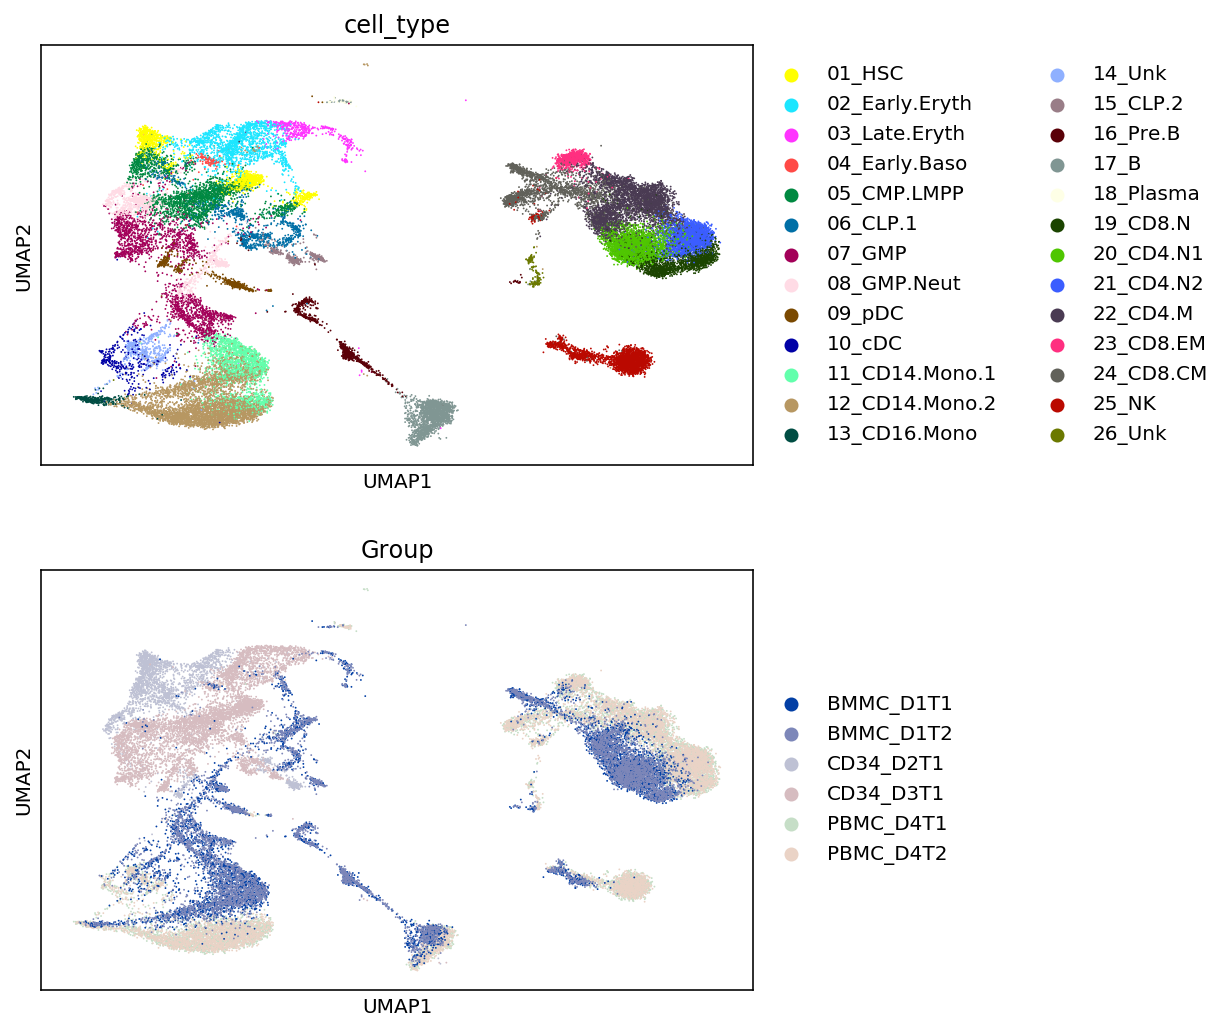

In [25]:
sc.pl.umap(adata[adata.obs['condition'] == 'control'], color=['cell_type', 'Group'], ncols=1)

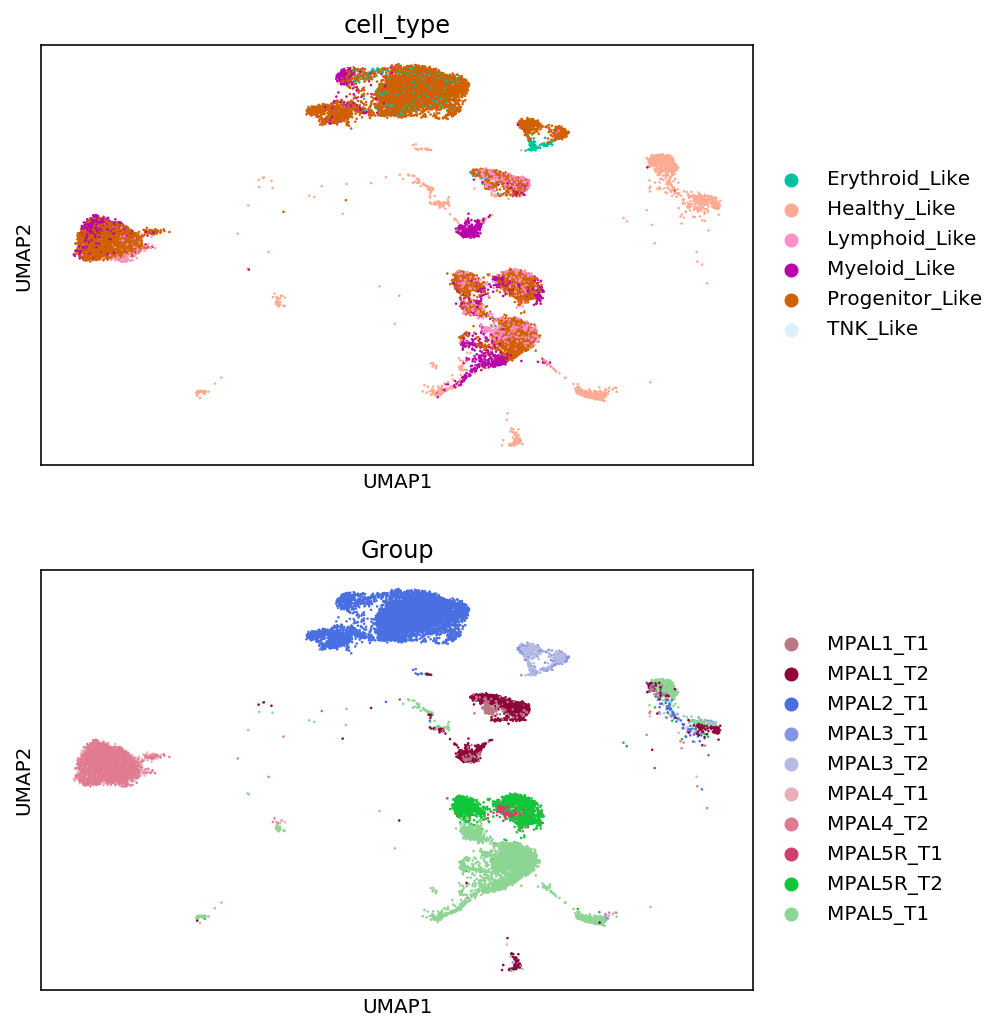

In [26]:
sc.pl.umap(adata[adata.obs['condition'] == 'stimulated'], color=['cell_type', 'Group'], ncols=1)

# Save the result

In [27]:
%time scrna.write(SCRNA_DIR + 'expressions.h5ad')

CPU times: user 264 ms, sys: 160 ms, total: 424 ms
Wall time: 1.16 s
